**Welcome to the Eco2AI Replication Project**


This notebook replicates selected results from the paper **"Eco2AI: A Framework for Energy Consumption and CO₂ Emission Tracking in AI Experiments"** (Budennyy et al., 2022).

The aim of this project was to reproduce key emission tracking outputs by training a simple Convolutional Neural Network (CNN) on the MNIST dataset while logging carbon emissions using the Eco2AI Python package.

**🛠 Setup instructions
If required, install dependencies:**




In [1]:
!pip install numpy pandas matplotlib pillow torch torchvision eco2ai

In [2]:
# Suppress Future Warnings for Cleaner Output
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [3]:
# Import Libraries
import eco2ai
from eco2ai import track

In [4]:
# Load Core Libraries for Model Development and Utilities
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from PIL import Image
import os

In [5]:
# Prepare and Load MNSIT Dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

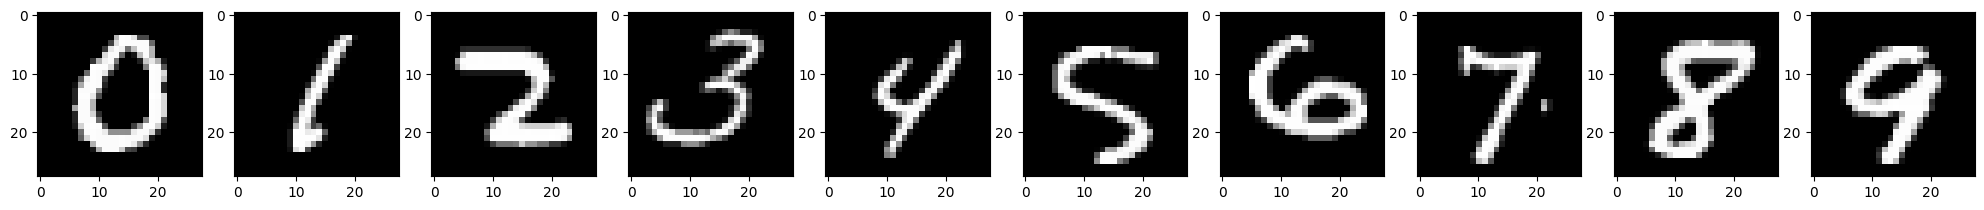

In [6]:
# Visualise Sample Images
fig, axs = plt.subplots(1, 10, figsize=(25, 3))
for i in range(10):
    label_indexes = [idx for idx, (_, label) in enumerate(train_dataset) if label == i]
    index = random.choice(label_indexes)
    img, _ = train_dataset[index]
    axs[i].imshow(img.squeeze(), cmap='gray')
plt.show()

In [7]:
# Create Data Loaders to Prepare Batches for Training and Testing
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
# Define the CNN  Model Arhitecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.batch_norm = nn.BatchNorm2d(1)
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.25)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 14 * 14, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.batch_norm(x)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [9]:
# Model Training and Evaluation Loop

# Train the model and evaluate accuracy on the validation set
def train(model, loader, criterion, optimizer, epochs=3):
    history = {'train_acc': [], 'val_acc': []}
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for epoch in range(epochs):
        model.train() # Set model to training mode
        correct, total = 0, 0 # Track correct predictions and total samples

        # Training Loop
        for x, y in loader:
            x, y = x.to(device), y.to(device) # Move data to GPU or CPU
            optimizer.zero_grad() # Clear previous gradients
            outputs = model(x) # Forward pass: generate predictions
            loss = criterion(outputs, y) # Compute loss against true labels
            loss.backward() # Backpropagate gradients
            optimizer.step() # Update weights


            _, predicted = outputs.max(1) # Get class with highest score
            total += y.size(0)
            correct += (predicted == y).sum().item()

        train_acc = correct / total  # Compute accuracy
        history['train_acc'].append(train_acc)

        # Validation Loop
        model.eval() # Set model to evaluation mode
        correct, total = 0, 0
        with torch.no_grad(): # Disable gradient tracking during evaluation
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                outputs = model(x)
                _, predicted = outputs.max(1)
                total += y.size(0)
                correct += (predicted == y).sum().item()

        val_acc = correct / total # Compute validation accuracy
        history['val_acc'].append(val_acc)

        # Print summary after each epoch
        print(f"Epoch {epoch + 1}/{epochs}, Train Accuracy: {train_acc:.4f}, Val Accuracy: {val_acc:.4f}")

    return history # Return accuracy results for later use


In [10]:
# Begin Emissions Tracking and Train Model

# Emissions Tracking - Run 1 (3 Epochs, Batch Size = 256)
tracker = eco2ai.Tracker(project_name="mnist_replication", experiment_description="3 epochs, batch size 256", file_name="emission.csv")

tracker.start() # Begin tracking energy usage and emissions

# Define data loaders with a batch size of 256
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# Set up model, loss fucntion and optimiser
model = SimpleCNN().to("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model for 3 epochs and collect accuracy stats
history = train(model, train_loader, criterion, optimizer, epochs=3)

tracker.stop() # End emissions tracking


/usr/local/lib/python3.11/dist-packages/eco2ai/emission_track.py:140: UserWarning: 
If you use a VPN, you may have problems with identifying your country by IP.
It is recommended to disable VPN or
manually set up the ISO-Alpha-2 code of your country during initialization of the Tracker() class.
You can find the ISO-Alpha-2 code of your country here: https://www.iban.com/country-codes

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/eco2ai/tools/tools_gpu.py:42: NoGPUWarning: There is no any available GPU devices or your GPU is not supported by Nvidia library!
The tracker will consider CPU usage only
  warnings.warn(


Epoch 1/3, Train Accuracy: 0.8424, Val Accuracy: 0.9653
Epoch 2/3, Train Accuracy: 0.9418, Val Accuracy: 0.9770
Epoch 3/3, Train Accuracy: 0.9546, Val Accuracy: 0.9814


In [11]:
# Emissions Tracking – Run 2 (2 Epochs, Batch Size = 128)

# Trains the same CNN using a smaller batch size (128) and fewer epochs (2)
# Useful for comparing how batch size and training time affect emissions and accuracy

tracker = eco2ai.Tracker(project_name="mnist_replication", experiment_description="2 epochs, batch size 128", file_name="emission.csv")
tracker.start()

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

model = SimpleCNN().to("cuda" if torch.cuda.is_available() else "cpu")
optimizer = optim.Adam(model.parameters(), lr=0.001)

history = train(model, train_loader, criterion, optimizer, epochs=2)

tracker.stop()


/usr/local/lib/python3.11/dist-packages/eco2ai/emission_track.py:140: UserWarning: 
If you use a VPN, you may have problems with identifying your country by IP.
It is recommended to disable VPN or
manually set up the ISO-Alpha-2 code of your country during initialization of the Tracker() class.
You can find the ISO-Alpha-2 code of your country here: https://www.iban.com/country-codes

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/eco2ai/tools/tools_gpu.py:42: NoGPUWarning: There is no any available GPU devices or your GPU is not supported by Nvidia library!
The tracker will consider CPU usage only
  warnings.warn(


Epoch 1/2, Train Accuracy: 0.8971, Val Accuracy: 0.9738
Epoch 2/2, Train Accuracy: 0.9592, Val Accuracy: 0.9833


In [12]:
# Emissions Tracking – Run 3 (4 Epochs, Batch Size = 64)
tracker = eco2ai.Tracker(project_name="mnist_replication", experiment_description="4 epochs, batch size 64, SGD", file_name="emission.csv")
tracker.start()

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model = SimpleCNN().to("cuda" if torch.cuda.is_available() else "cpu")
optimizer = optim.SGD(model.parameters(), lr=0.01)

history = train(model, train_loader, criterion, optimizer, epochs=4)

tracker.stop()


/usr/local/lib/python3.11/dist-packages/eco2ai/emission_track.py:140: UserWarning: 
If you use a VPN, you may have problems with identifying your country by IP.
It is recommended to disable VPN or
manually set up the ISO-Alpha-2 code of your country during initialization of the Tracker() class.
You can find the ISO-Alpha-2 code of your country here: https://www.iban.com/country-codes

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/eco2ai/tools/tools_gpu.py:42: NoGPUWarning: There is no any available GPU devices or your GPU is not supported by Nvidia library!
The tracker will consider CPU usage only
  warnings.warn(


Epoch 1/4, Train Accuracy: 0.7533, Val Accuracy: 0.9277
Epoch 2/4, Train Accuracy: 0.8860, Val Accuracy: 0.9443
Epoch 3/4, Train Accuracy: 0.9179, Val Accuracy: 0.9632
Epoch 4/4, Train Accuracy: 0.9401, Val Accuracy: 0.9728


In [13]:
# Load the emissions CSV and display the last 3 tracked runs
df = pd.read_csv("emission.csv")
display(df.tail(3))

,id,project_name,experiment_description,epoch,start_time,duration(s),power_consumption(kWh),CO2_emissions(kg),CPU_name,GPU_name,OS,region/country,cost
4,a3527c9a-e6b4-4642-918c-73f2de04af6b,mnist_replication,"3 epochs, batch size 256",NaN,2025-04-07 23:18:14,201.645605,0.001684,0.000411,"Intel(R) Xeon(R) CPU @ 2.20GHz/1 device(s), TD...",0 device(s),Linux,US/South Carolina,0
5,9e9cc9e2-f858-4f1c-93fe-0f958c2518f6,mnist_replication,"2 epochs, batch size 128",NaN,2025-04-07 23:21:37,115.242874,0.000942,0.000230,"Intel(R) Xeon(R) CPU @ 2.20GHz/1 device(s), TD...",0 device(s),Linux,US/South Carolina,0
6,d9307c2c-bab3-40fb-83a1-53b28f789872,mnist_replication,"4 epochs, batch size 64, SGD",NaN,2025-04-07 23:23:34,231.069237,0.001967,0.000480,"Intel(R) Xeon(R) CPU @ 2.20GHz/1 device(s), TD...",0 device(s),Linux,US/South Carolina,0
